In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
import os
import csv
import random
from math import log

import tensorflow 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Embedding, Dense, TimeDistributed, Concatenate, AdditiveAttention 

In [3]:
# Install wandb and wandbcallback libraries
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 52.4 MB/s 
     |████████████████████████████████| 181 kB 45.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


In [4]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import HTML as html_print
import time
from IPython.display import clear_output

# Download the dataset


In [5]:
# Download the dataset
if not os.path.exists('/content/dakshina_dataset_v1.0.tar'):
    !wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2022-05-07 06:27:05--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   139MB/s    in 11s     

2022-05-07 06:27:16 (167 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [6]:
# Unzip every file
!tar -xvf /content/dakshina_dataset_v1.0.tar

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

In [7]:
# Load the training dataset file
train_file = open("/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv")
read_train_file = csv.reader(train_file, delimiter="\t")

# Load the validation dataset file
val_file = open("/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv")
read_val_file = csv.reader(val_file, delimiter="\t")

# Load the test dataset file
test_file = open("/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv")
read_test_file = csv.reader(test_file, delimiter="\t")

# Path to save the predictions file
predictions_path = 'predictions.tsv'

# Preprocess and Encode Data

In [8]:
# Get all the input words(English) and target words(Telugu) in Training dataset
telugu_words = []
english_words = []

for i in read_train_file:   
    telugu_words.append("\t" + str(i[0]) + "\n")
    english_words.append(str(i[1]))

# Get all the input words(English) and target words(Telugu) in Validation dataset
val_telugu_words = []
val_english_words = []

for i in read_val_file:
    val_telugu_words.append("\t" + str(i[0]) + "\n")
    val_english_words.append(str(i[1]))


# Get all the input words(English) and target words(Telugu) in Test dataset
test_telugu_words = []
test_english_words = []

for i in read_test_file:
    test_telugu_words.append("\t" + str(i[0]) + "\n")
    test_english_words.append(str(i[1]))


In [9]:
# Get the total list of input words(English)
total_input_words = english_words + val_english_words + test_english_words

# Get the total list of target words(Telugu)
total_output_words = telugu_words + val_telugu_words + test_telugu_words

In [10]:
# Get the total input and target language characters 

english_characters = set()
english_characters.add(" ")
telugu_characters = set()
telugu_characters.add(" ")

for word in total_input_words:
    for char in word:
        if char not in english_characters:
            english_characters.add(char)

for word in total_output_words:
    for char in word:
        if char not in telugu_characters:
            telugu_characters.add(char)

In [11]:
# Sort the list of input characters(English) and target characters(Telugu)
english_characters = sorted(list(english_characters))
telugu_characters = sorted(list(telugu_characters))

# Get total number of characters in Input 
num_encoder_tokens = len(english_characters)
# Get total number of characters in Output 
num_decoder_tokens = len(telugu_characters)

# Get maximum length of the word in total input words
max_encoder_seq_length = max([len(text) for text in total_input_words])
# Get maximum length of the word in total target words
max_decoder_seq_length = max([len(text) for text in total_output_words])

print("Summary of the dataset :")
print("Number of train samples :" , len(english_words))
print("Number of val samples :" , len(val_english_words))
print("Number of test samples :" , len(test_english_words))
print("Number of unique input tokens :" , num_encoder_tokens)
print("Number of unique output tokens :" , num_decoder_tokens)
print("Max sequence length for inputs:" , max_encoder_seq_length)
print("Max sequence length for outputs:" , max_decoder_seq_length)

Summary of the dataset :
Number of train samples : 58550
Number of val samples : 5683
Number of test samples : 5747
Number of unique input tokens : 27
Number of unique output tokens : 66
Max sequence length for inputs: 25
Max sequence length for outputs: 22


In [12]:
# Dictionary for every english character with an index associated to it
input_token_index = dict([(char, i) for i, char in enumerate(english_characters)])
# Dictionary for every telugu character with an index associated to it
target_token_index = dict([(char, i) for i, char in enumerate(telugu_characters)])

# Dictionary for every english character with an index associated to it
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
# Dictionary for every english character with an index associated to it
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

# Preparing train encoder and decoder inputs and decoder target
encoder_input_data = np.zeros((len(english_words), max_encoder_seq_length), dtype="float32")
decoder_input_data = np.zeros((len(english_words), max_decoder_seq_length), dtype="float32")
decoder_target_data = np.zeros((len(english_words), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# Writing the encoder , decoder characters with the indexes in input and target token index 
for i, (english, telugu) in enumerate(zip(english_words, telugu_words)):
    for t, char in enumerate(english):
        encoder_input_data[i, t] = input_token_index[char]
    
    for t, char in enumerate(telugu):
        decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # One got encoding the decoder_target_data  and decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0    
    decoder_input_data[i, t+1:] = target_token_index[' ']
    decoder_target_data[i, t :, target_token_index[' ']] = 1.0

In [13]:
# Preparing validation encoder and decoder inputs

encoder_val_input_data = np.zeros((len(val_english_words), max_encoder_seq_length), dtype="float32")
decoder_val_input_data = np.zeros((len(val_english_words), max_decoder_seq_length), dtype="float32")
decoder_val_target_data = np.zeros((len(val_english_words), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (english, telugu) in enumerate(zip(val_english_words, val_telugu_words)):
    for t, char in enumerate(english):
        encoder_val_input_data[i, t] = input_token_index[char]
  
    for t, char in enumerate(telugu):
        decoder_val_input_data[i, t] =  target_token_index[char]
        if t > 0:
            # One got encoding the validation decoder target data  and validation decoder target data will be ahead by one timestep and will not include the start character.
            decoder_val_target_data[i, t - 1, target_token_index[char]] = 1.0   
    decoder_val_input_data[i, t+1:] = target_token_index[' ']
    decoder_val_target_data[i, t :, target_token_index[' ']] = 1.0

In [14]:
# Preparing test encoder and decoder inputs

encoder_test_input_data = np.zeros((len(test_english_words), max_encoder_seq_length), dtype="float32")
decoder_test_input_data = np.zeros((len(test_english_words), max_decoder_seq_length), dtype="float32")
decoder_test_target_data = np.zeros((len(test_english_words), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (english, telugu) in enumerate(zip(test_english_words, test_telugu_words)):
    for t, char in enumerate(english):
        encoder_test_input_data[i, t] = input_token_index[char]
  
    for t, char in enumerate(telugu):
        decoder_test_input_data[i, t] =  target_token_index[char]
        if t > 0:
            # One got encoding the validation decoder target data  and validation decoder target data will be ahead by one timestep and will not include the start character.
            decoder_test_target_data[i, t - 1, target_token_index[char]] = 1.0   
    decoder_test_input_data[i, t+1:] = target_token_index[' ']
    decoder_test_target_data[i, t :, target_token_index[' ']] = 1.0

In [15]:
# Converting the validation telugu and english words to numpy arrays
val_telugu_words = np.array(val_telugu_words)
val_english_words = np.array(val_english_words)

# Converting the test telugu and english words to numpy arrays
test_telugu_words = np.array(test_telugu_words)
test_english_words = np.array(test_english_words)

In [16]:
with open(predictions_path, 'w') as f:
        f.write('Input English Words, Predicted Telugu Words, Actual Telugu Words\n')

# Train and Build Model

In [17]:
class CustomRNN(object):
    
    def __init__(self, input_embedding_size, cell_type='GRU', hidden_layer_size=32,
                 num_encoder_layers=2, num_decoder_layers = 2, dropout=0.1, 
                 batch_size=32, epochs=25, is_test_model=False):

        self.cell_type = cell_type
        self.input_embedding_size = input_embedding_size
        self.cell_type = cell_type
        self.hidden_layer_size = hidden_layer_size
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.is_test_model = is_test_model


    def training(self):
        """
        Method to train the model using LSTM or GRU or RNN and
        return model along with encoder_layers and decoder_layers.
        """

        # Choose customFunction based on cell_type
        customFunction = None
        if self.cell_type == 'LSTM':
            customFunction = LSTM
        elif self.cell_type == 'GRU':
            customFunction = GRU
        elif self.cell_type == 'RNN':
            customFunction = SimpleRNN

        # Encoders
        encoder_inputs = Input(shape=(None,))
        encoder_embedding = Embedding(num_encoder_tokens,self.input_embedding_size, input_length = max_encoder_seq_length)(encoder_inputs)
        
        # get encoder_layers and encoder_states
        encoder_layers = []
        encoder_states = []    
        if self.cell_type == 'LSTM':
            encoder = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
            encoder_layers.append(encoder)
            encoder_outputs, state_h, state_c = encoder(encoder_embedding)
            encoder_states.append([state_h, state_c])

            for i in range(1,self.num_encoder_layers):
                encoder = customFunction(self.hidden_layer_size,return_sequences=True,return_state=True, dropout = self.dropout) 
                encoder_layers.append(encoder)
                encoder_outputs, state_h, state_c = encoder(encoder_outputs)
                encoder_states.append([state_h, state_c])
        else:
            encoder = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
            encoder_layers.append(encoder)
            encoder_outputs, state_h = encoder(encoder_embedding)
            encoder_states.append([state_h])

            for i in range(1,self.num_encoder_layers):
                encoder = customFunction(self.hidden_layer_size,return_sequences=True,return_state=True, dropout = self.dropout) 
                encoder_layers.append(encoder)
                encoder_outputs, state_h = encoder(encoder_outputs)
                encoder_states.append([state_h])
        
        # Decoders
        decoder_inputs = Input(shape=(None,))
        decoder_embedding = Embedding(num_decoder_tokens,self.input_embedding_size, input_length = max_decoder_seq_length)(decoder_inputs)

        # get decoder_layers
        decoder_layers = []
        if self.cell_type == 'LSTM':
            decoder_lstm = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
            decoder_layers.append(decoder_lstm)
            decoder_outputs, _ , _ = decoder_lstm(decoder_embedding, initial_state=encoder_states[0])
            for i in range(1,self.num_decoder_layers):
                decoder_lstm = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
                decoder_layers.append(decoder_lstm)
                decoder_outputs, _ , _  = decoder_lstm(decoder_outputs, initial_state=encoder_states[i])
        else:
            decoder_GRU = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
            decoder_layers.append(decoder_GRU)
            decoder_outputs, _ = decoder_GRU(decoder_embedding, initial_state=encoder_states[0])
            for i in range(1,self.num_decoder_layers):
                decoder_GRU = customFunction(self.hidden_layer_size, return_sequences=True, return_state=True, dropout = self.dropout)
                decoder_layers.append(decoder_GRU)
                decoder_outputs, _  = decoder_GRU(decoder_outputs, initial_state=encoder_states[i])

        # Add decoder attention layer
        decoder_attention = AdditiveAttention(name="decoder_attention")
        decoder_concat = Concatenate(name="decoder_concat")
        context_vector, _ = decoder_attention([decoder_outputs, encoder_outputs], return_attention_scores=True)
        decoder_outputs = decoder_concat([decoder_outputs, context_vector])
        
        # Add dense layer to decoder
        decoder_dense = Dense(num_decoder_tokens, activation="softmax")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Create a model, compile and fit the model using the optimizer.
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        # If test_model, do not add wandb callback
        if self.is_test_model:
            model.fit(
                [encoder_input_data, decoder_input_data],
                decoder_target_data,
                batch_size=self.batch_size,
                epochs=self.epochs
            )
        else:
            model.fit(
                [encoder_input_data, decoder_input_data],
                decoder_target_data,
                batch_size=self.batch_size,
                epochs=self.epochs,
                callbacks=[WandbCallback()]
            )

        return model, encoder_layers, decoder_layers


    def inference_model(self, model, encoder_layers, decoder_layers):
        """
        Create the encoder_model, decoder_model and return using the
        arguments model, encoder_layers and decoder_layers
        """
        
        # generate encoder_model 
        encoder_inputs = model.input[0]  # input_1
        encoder_states = []
        enc_emb = model.layers[2]     # embedding 1
        encoder_outputs = enc_emb(encoder_inputs)

        if self.cell_type == 'RNN' or self.cell_type =="GRU":
            for i in range(self.num_encoder_layers):
                encoder_outputs, state_h_enc = encoder_layers[i](encoder_outputs)
                encoder_states += [state_h_enc] 
        else:
            for i in range(self.num_encoder_layers):
                encoder_outputs, state_h_enc, state_c_enc = encoder_layers[i](encoder_outputs)
                encoder_states += [state_h_enc, state_c_enc]   

        encoder_model = Model(encoder_inputs, encoder_states + [encoder_outputs])


        # generate decoder_model
        input_names = [["input_100","input_101"],["input_102","input_103"],["input_104","input_105"],"input_106"]

        decoder_inputs = model.input[1]       # input_2
        decoder_embedding = model.layers[3]   # embedding 2
        decoder_outputs = decoder_embedding(decoder_inputs)
        decoder_states = []
        decoder_states_inputs = []
        
        if self.cell_type == 'RNN' or self.cell_type =="GRU":
            for i in range(self.num_decoder_layers):
                decoder_states_inputs += [Input(shape=(self.hidden_layer_size,), name=input_names[i][0])]
            for i in range(self.num_decoder_layers):
                decoder_outputs, state_h_dec = decoder_layers[i](decoder_outputs, initial_state=decoder_states_inputs[i])
                decoder_states += [state_h_dec]
        else:
            for i in range(self.num_decoder_layers):
                decoder_states_inputs += [Input(shape=(self.hidden_layer_size,), name=input_names[i][0]), Input(shape=(self.hidden_layer_size,), name=input_names[i][1])]
            j = 0
            for i in range(self.num_decoder_layers):
                decoder_outputs, state_h_dec, state_c_dec = decoder_layers[i](decoder_outputs, initial_state=decoder_states_inputs[i+j:i+j+2])
                decoder_states += [state_h_dec , state_c_dec]
                j += 1

        attention_layer = model.layers[4+2*self.num_encoder_layers]
        attention_input = Input(shape=(max_encoder_seq_length,self.hidden_layer_size), name=input_names[-1])   
        context_vec, attention_weights = attention_layer([decoder_outputs, attention_input], return_attention_scores=True)
        
        concat_layer = model.layers[5+2*self.num_encoder_layers]
        decoder_outputs = concat_layer([decoder_outputs, context_vec])

        decoder_dense = model.layers[6+2*self.num_encoder_layers]
        decoder_outputs = decoder_dense(decoder_outputs)
        decoder_model = Model([decoder_inputs] + decoder_states_inputs + [attention_input], [decoder_outputs] + decoder_states + [attention_weights])

        return encoder_model, decoder_model


    def decode_sequence(self, input_seq, encoder_model, decoder_model):
        """
        Method to decode an input sequence using the encoder_model
        and decoder_model
        """
        states_value = encoder_model.predict(input_seq)

        # get attention input
        attention_input = states_value[-1]
        states_value = states_value[:-1]
        target_seq = np.zeros((1, 1)) 
        target_seq[0, 0] = target_token_index["\t"]
        attention_weights = []

        # continue decoding input sequence till '\n' is found or the sequence
        # exceeds the maximum decoder sequence length.
        stop_condition = False
        decoded_sentence = ""
        while not stop_condition:
            output_tokens = decoder_model.predict([target_seq] + states_value + [attention_input])
            sampled_token_index = np.argmax(output_tokens[0][0, -1, :])
            sampled_char = reverse_target_char_index[sampled_token_index]
            decoded_sentence += sampled_char
            if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
                stop_condition = True

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            states_value = output_tokens[1:-1]
            attention_weights.append(output_tokens[-1][0][0])
            
        return decoded_sentence, attention_weights

    
    def test_and_calculate_accuraccy(self, encoder_model, decoder_model, tmp_english_words, 
                                     tmp_telugu_words, tmp_encoder_input_data, is_val_accuracy=True):
        """
        Calculate accuracy using the data and write it to prediction file.
        """
        correct = 0
        n = tmp_telugu_words.shape[0]
        for i in range(n):
            input = tmp_encoder_input_data[i:i+1]
            output, _ = self.decode_sequence(input,encoder_model, decoder_model)
            with open(predictions_path, 'a') as f:
                    f.write('{} , {} , {}\n'.format(tmp_english_words[i].strip(), output.strip(), tmp_telugu_words[i].strip()))
            if output.strip() == tmp_telugu_words[i].strip():
                correct += 1

        # log accuracy to wandb
        if is_val_accuracy:
            wandb.log({'val_accuracy' : correct*100/n})
            print('val_accuracy', correct*100/n)
        else:
            wandb.log({'test_accuracy' : correct*100/n})
            print('test_accuracy', correct*100/n)



# Sweep config

In [18]:
sweep_config = {
    'method': 'bayes',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'input_embedding_size':
        {
            'values': [128, 256, 512]
        },
        'hidden_layer_size':
        {
            'values': [128, 256, 512]
        },
        'cell_type':
        {
            'values': ['LSTM', 'RNN', 'GRU']
        },
        'num_layers':
        {
            'values': [1, 2, 3]
        },
        'batch_size':
        {
            'values': [128, 256, 512]
        },
        'dropout':
        {
            'values': [0.1]
        },
        'epochs':
        {
            'values': [25]
        }
    }
}


In [19]:
sweep_id = wandb.sweep(sweep_config, entity="cs21m010-cs21m041", project="DL_Assignment_3_b")

In [20]:
def train():

    # Create a new WandB run
    wandb.init(config=sweep_config)
    
    # Construct the run name
    config = wandb.config
    wandb.run.name = 'ATT_' + config.cell_type + '' + str(config.input_embedding_size) + '_hs' + str(config.hidden_layer_size) + 'bs' + str(config.batch_size)
    
    print('training...')
    model_rnn_obj = CustomRNN(config.input_embedding_size, config.cell_type , config.hidden_layer_size, 
                              config.num_layers, config.num_layers, config.dropout, config.batch_size, config.epochs)
    model, encoder_layers, decoder_layers = model_rnn_obj.training()    

    print('inferrencing...')
    encoder_model, decoder_model = model_rnn_obj.inference_model(model, encoder_layers, decoder_layers)
    
    print('decoding sequence...')
    model_rnn_obj.test_and_calculate_accuraccy(encoder_model, decoder_model, val_english_words, val_telugu_words, encoder_val_input_data)

In [21]:
wandb.agent(sweep_id, train, count = 15)

# Fitting the Best Model

In [28]:
best_sweep_config = {
    'method': 'random',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'input_embedding_size':
        {
            'values': [128]
        },
        'hidden_layer_size':
        {
            'values': [512]
        },
        'cell_type':
        {
            'values': ['GRU']
        },
        'num_layers':
        {
            'values': [1]
        },
        'batch_size':
        {
            'values': [128]
        },
        'dropout':
        {
            'values': [0.1]
        },
        'epochs':
        {
            'values': [25]
        }
    }
}

In [29]:
sweep_id = wandb.sweep(best_sweep_config, entity="cs21m010-cs21m041", project="DL_Assignment_3_b")

Create sweep with ID: 460y1xof
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_3_b/sweeps/460y1xof


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Visualize using the heatmap
def visualize_heatmap(input_words, prediction_words, attention_weights):
    figures = []
    n = 9 
    figures , axs = plt.subplots(3,3)
    figures.set_size_inches(23, 15)
    l = -1

    k = 0
    for i in range(n):
        output = prediction_words[i]
        attn_weights = attention_weights[i]
        ylabel = [""]
        m = len(attn_weights)

        chars_ = [x for x in output]
        xlabel = [""]
        ylabel += chars_
        xlabel += [char for char in input_words[i]]
        
        for j in range(m):
            attn_weights[j] = attn_weights[j][1:len(xlabel)]
            
        attn_weights = attn_weights[:-1]
        if i%3 == 0:
            l+=1
            k=0
            
        cax = axs[l][k].matshow(np.array(attn_weights))
        axs[l][k].set_xticklabels(xlabel)
        fontProps = FontProperties(fname = "/content/drive/MyDrive/fonts/nirmala.ttf")
        axs[l][k].set_yticklabels(ylabel, fontproperties=fontProps)
        k+=1

    plt.show()

In [65]:
# Consider Best configuration
def consider_best_model():
    
    # Create a new WandB run
    wandb.init(config=best_sweep_config)
    
    # Construct the run name
    config = wandb.config
    wandb.run.name = 'ATT_Best_' + config.cell_type + '' + str(config.input_embedding_size) + '_hs' + str(config.hidden_layer_size) + 'bs' + str(config.batch_size)
    
    # Taking Best configuration
    print('training...')
    best_model_obj = CustomRNN(config.input_embedding_size, config.cell_type , config.hidden_layer_size, 
              config.num_layers, config.num_layers, config.dropout, 
              config.batch_size, config.epochs, is_test_model=True)
    model, encoder_layers, decoder_layers = best_model_obj.training()

    print('inferrencing...')
    encoder_model, decoder_model = best_model_obj.inference_model(model, encoder_layers, decoder_layers)

    print('calculating test accuracy and decoding test inputs...')
    best_model_obj.test_and_calculate_accuraccy(encoder_model, decoder_model, test_english_words, 
                                              test_telugu_words, encoder_test_input_data, is_val_accuracy=False)
    

    indexes = [700, 994, 1070, 1111, 1206, 1441, 1691, 1977, 2535]
    inputs = []
    predictions = []
    attentions = []

    for i in indexes:
        input = encoder_test_input_data[i:i+1]
        inputs.append(test_english_words[i].strip())
        output, attention_weights = best_model_obj.decode_sequence(input, encoder_model, decoder_model)
        predictions.append(output.strip())
        attentions.append(attention_weights)

    visualize_heatmap(inputs, predictions, attentions)


wandb: Agent Starting Run: ai5jfens with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	epochs: 1
wandb: 	hidden_layer_size: 512
wandb: 	input_embedding_size: 128
wandb: 	num_layers: 1


training...
458/458 [==============================] - 53s 107ms/step - loss: 1.1730 - accuracy: 0.6880
inferrencing...


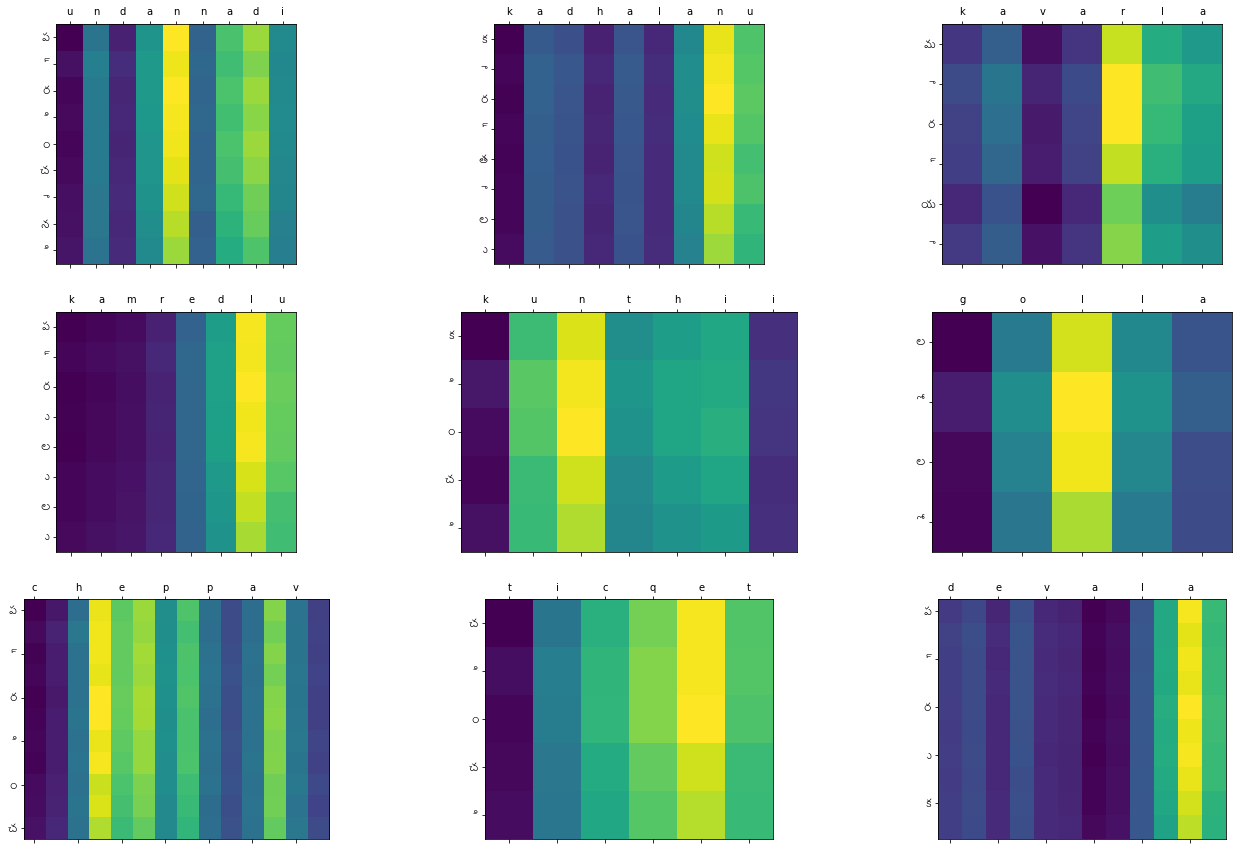

In [66]:
wandb.agent(sweep_id, consider_best_model, count=1)